In [1]:
%%time
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
from scipy.sparse import coo_matrix, diags, hstack, vstack, identity
from scipy.sparse.linalg import eigsh


dataset = 'gowalla'

if dataset == 'yelp2018':
    P0_, P1_ = False, False
    PHI = 0.8
elif dataset == 'gowalla':
    P0_, P1_ = True, True
    PHI = 0.7
D_TYPE, TOP_K, DIM = np.float32, 20, 512
train_file = './input/' + dataset + '/train.txt'
test_file = './input/' + dataset + '/test.txt'

CPU times: user 4.22 s, sys: 3.99 s, total: 8.21 s
Wall time: 4.51 s


In [2]:
%%time
user_nums = 0
item_nums = 0
R_I = [[], []]
with open(train_file) as f:
    for _ in f.readlines():
        user_nums += 1
        _ = _.strip().split(' ')
        items = [int(i) for i in _[1:]]
        uid = int(_[0])
        R_I[0] += [uid] * len(items)
        R_I[1] += items
        max_item = max(items)
        item_nums = max(item_nums, max_item)
    item_nums += 1
R_I = np.array(R_I)
R_V = np.array([1] * len(R_I[0]), dtype=D_TYPE)
R = coo_matrix((R_V, R_I), shape=(user_nums, item_nums))

ground_truth = dict()
with open(test_file) as f:
    for _ in f.readlines():
        _ = _.strip().split(' ')
        items = [int(i) for i in _[1:]]
        uid = int(_[0])
        if len(items) > 0:
            ground_truth[uid] = items
test_user_nums = len(ground_truth)

CPU times: user 589 ms, sys: 58.2 ms, total: 647 ms
Wall time: 710 ms


In [3]:
%%time
Du_ = diags(np.power(R.sum(axis=1).T.A[0], -1/2), offsets=0)
Di_ = diags(np.power(R.sum(axis=0).A[0], -1/2), offsets=0)
Du = diags(np.power(R.sum(axis=1).T.A[0], 1/2), offsets=0)
Di = diags(np.power(R.sum(axis=0).A[0], 1/2), offsets=0)

Ru = Du_ * R
Ri = R * Di_

Cu = Ri * Ri.T
Ci = Ru.T * Ru

R_post = Ru * Di_
Ci0 = R_post.T * R_post
Cu0 = R_post * R_post.T 

CPU times: user 4.75 s, sys: 776 ms, total: 5.53 s
Wall time: 5.54 s


In [4]:
%%time
A = vstack([hstack([Cu, R]), hstack([R.T, Ci])])
I = identity(user_nums + item_nums, dtype=D_TYPE)
D_ = diags(np.power(A.sum(axis=0).A[0], -1/2), offsets=0)
A_norm = D_ * A * D_
L_norm = I - A_norm

CPU times: user 13.2 s, sys: 5.48 s, total: 18.6 s
Wall time: 18.7 s


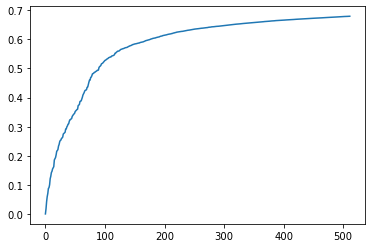

CPU times: user 2h 25min 13s, sys: 2min 10s, total: 2h 27min 24s
Wall time: 12min 38s


In [5]:
%%time
vec_file = './temp/eig/vec_' + dataset + '_{}'.format(DIM) + '.npy'
val_file = './temp/eig/val_' + dataset + '_{}'.format(DIM) + '.npy'

if not os.path.exists(vec_file):
    val, vec = eigsh(L_norm, k=DIM, which='SA')
    np.save(vec_file, vec)
    np.save(val_file, val)
else:
    vec = np.load(vec_file)
    val = np.load(val_file)

plt.plot(val)
plt.show()

In [6]:
%%time
R_b = hstack([Cu0, R])
D_Rb_i_ = diags(np.power(R_b.sum(axis=0).A[0], -1/2), offsets=0)
D_Rb_i = diags(np.power(R_b.sum(axis=0).A[0], 1/2), offsets=0)
D_Rb_i = D_Rb_i.toarray()

CPU times: user 1.29 s, sys: 896 ms, total: 2.18 s
Wall time: 2.18 s


In [7]:
%%time
if P0_:
    P0_file = './temp/P0/' + dataset + '.npy'
    if not os.path.exists(P0_file):
        P0 = R * Di_
        P0 = P0 * Ci0
        P0 = P0 * Di
        P0 = P0.toarray()
        np.save(P0_file, P0)
    else:
        P0 = np.load(P0_file)
else:
    P0_file = './temp/P0/' + dataset + '_raw' + '.npy'
    if not os.path.exists(P0_file):
        P0 = R * Ci0
        P0 = P0.toarray()
        np.save(P0_file, P0)
    else:
        P0 = np.load(P0_file)

CPU times: user 24.5 s, sys: 9.42 s, total: 33.9 s
Wall time: 34 s


In [8]:
%%time
if P1_:
    P1_file = './temp/P1/' + dataset + '_{}'.format(DIM) + '.npy'
    if not os.path.exists(P1_file):
        P1 = R_b * D_Rb_i_
        P1 = P1 * vec
        P11 = np.matmul(vec.T, D_Rb_i)
        P1 = np.matmul(P1, P11)
        P1 = P1[:, user_nums:]
        np.save(P1_file, P1)
    else:
        P1 = np.load(P1_file)
else:
    P1_file = './temp/P1/' + dataset + '_{}_raw'.format(DIM) + '.npy'
    if not os.path.exists(P1_file):
        P1 = R_b * vec
        P1 = np.matmul(P1, vec.T)
        P1 = P1[:, user_nums:]
        np.save(P1_file, P1)
    else:
        P1 = np.load(P1_file)

CPU times: user 7min 55s, sys: 4min 2s, total: 11min 57s
Wall time: 1min 12s


In [9]:
%%time
P = PHI * P0 + (1 - PHI) * P1

P = torch.from_numpy(P)
for i, j in zip(R_I[0], R_I[1]):
    i, j = i.item(), j.item()
    P[i][j] = 1e-9  
_, pred_indexs = P.topk(TOP_K)

recall = 0.
precise = 0.
NDCG = 0.
for test_uid in range(user_nums):
    if ground_truth.get(test_uid):
        pred = pred_indexs[test_uid].tolist()
        # NDCG
        DCG = 0.
        IDCG = 0.
        for i in range(TOP_K):
            if pred[i] in ground_truth[test_uid]:
                DCG += (1 / np.log(2 + i))
        for i in range(min(TOP_K, len(ground_truth[test_uid]))):
            IDCG += (1 / np.log(2 + i))
        NDCG += (DCG / IDCG)
        # Recall Precise
        right = set(pred) & set(ground_truth[test_uid])
        up = len(right)
        down = len(ground_truth[test_uid])
        recall += (up / down)
        precise += (up / TOP_K)

recall /= test_user_nums
precise /= test_user_nums
f1 = 2 * recall * precise / (recall + precise)
NDCG /= test_user_nums
print(np.round(recall, 4), np.round(NDCG, 4))

0.1916 0.1605
CPU times: user 21.8 s, sys: 7.86 s, total: 29.6 s
Wall time: 20.5 s
